In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

mid = 288 # K
half_range = 30 # K
step = 10 # K
zt0_range = np.arange(mid-half_range, mid+half_range+step, step)
ne = len(zt0_range)
nt = 
ds_in_path = Path(f"/N/slate/jmelms/projects/FCN_dynamical_testing/data/output/dcmip2025/steady-state_nt={nt}_ne={ne}.nc")

In [14]:
ds = xr.open_dataset(ds_in_path)
variables = list(ds.keys())
ds = ds.assign_coords({"ensemble": zt0_range})
ds.keys()

KeysView(<xarray.Dataset> Size: 104GB
Dimensions:    (time: 49, level: 13, latitude: 721, longitude: 1440, ensemble: 7)
Coordinates:
  * time       (time) datetime64[ns] 392B 1850-01-01 ... 1850-01-13
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 12kB 0.0 0.2502 0.5003 ... 359.5 359.7 360.0
  * ensemble   (ensemble) int64 56B 258 268 278 288 298 308 318
Data variables: (12/13)
    VAR_10U    (time, ensemble, latitude, longitude) float32 1GB ...
    VAR_10V    (time, ensemble, latitude, longitude) float32 1GB ...
    VAR_100U   (time, ensemble, latitude, longitude) float32 1GB ...
    VAR_100V   (time, ensemble, latitude, longitude) float32 1GB ...
    VAR_2T     (time, ensemble, latitude, longitude) float32 1GB ...
    SP         (time, ensemble, latitude, longitude) float32 1GB ...
    ...         ...
    TCW        (time, ensemble, latitude, 

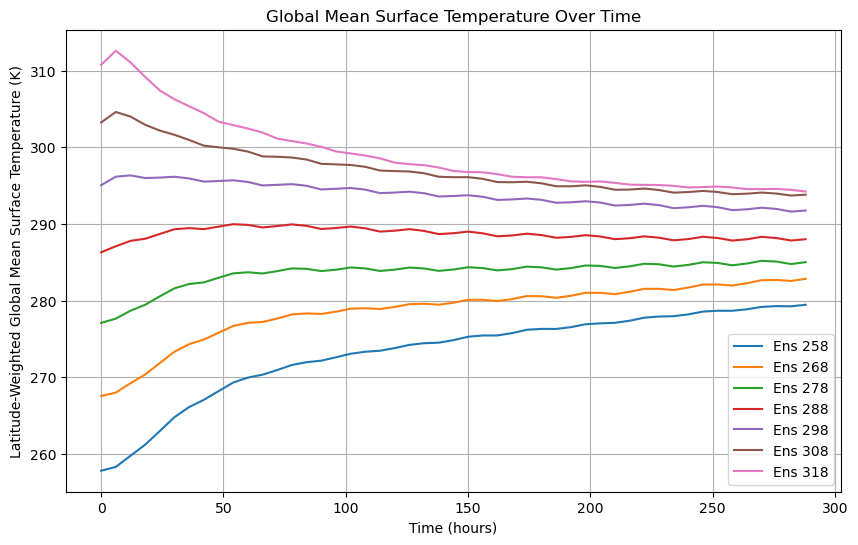

In [15]:
# Extract surface temperature variable
surface_temp = ds['VAR_2T']  # Shape: (time, ensemble, latitude, longitude)

# Convert latitude to radians for weighting
lat_radians = np.deg2rad(ds.latitude)

# Compute latitude weights using cosine weighting
weights = np.cos(lat_radians)

# Normalize weights to sum to 1 over latitude
weights /= weights.sum()

# Apply latitude weighting and take the global mean over lat/lon
global_mean_t = (surface_temp * weights).sum(dim="latitude").mean(dim="longitude")

# Now `global_mean_t` has shape (time, ensemble)
# Convert time to timedelta (hours since first time step)
time_hours = (ds.time - ds.time[0]) / np.timedelta64(1, "h")

# Plot the results
plt.figure(figsize=(10, 6))

for ens in ds.ensemble:
    plt.plot(time_hours, global_mean_t.sel(ensemble=ens), label=f'Ens {ens.values}')

plt.xlabel("Time (hours)")
plt.ylabel("Latitude-Weighted Global Mean Surface Temperature (K)")
plt.title("Global Mean Surface Temperature Over Time")
plt.legend()
plt.grid()
plt.show()


TypeError: Dimensions of C (7, 721, 1440) should be one smaller than X(1440) and Y(721) while using shading='flat' see help(pcolormesh)

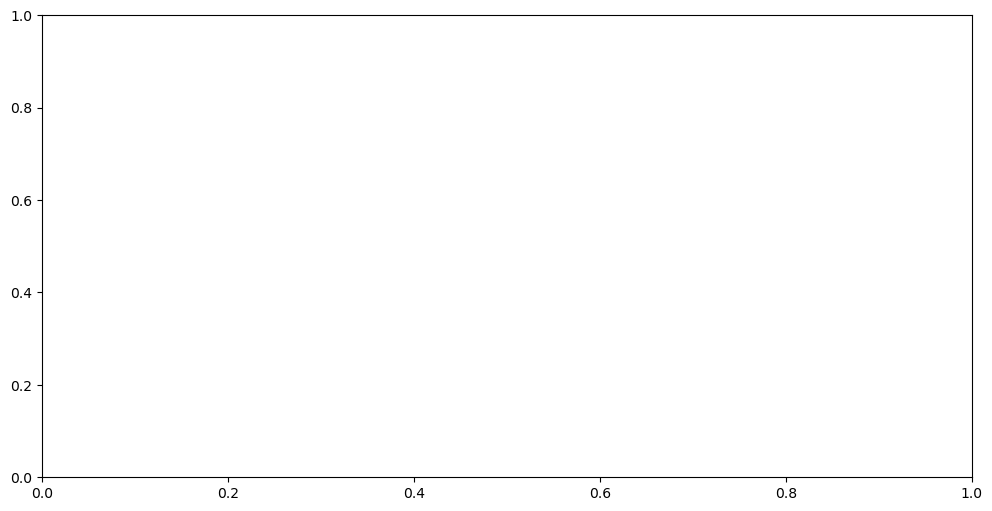

In [16]:
def plot_variable(ds, var_name, levels=None):
    """
    Plots the given variable from an xarray dataset over multiple timesteps.

    Parameters:
        ds (xarray.Dataset): The dataset containing the variable.
        var_name (str): Name of the variable to plot.
        levels (int or list, optional): Contour levels for the color scale.
    """
    # Extract variable and coordinates
    data = ds[var_name]
    times = ds.time.values
    lats = ds.latitude.values
    lons = ds.longitude.values

    # Convert times to hours since the first timestamp
    time_deltas = (times - times[0]) / np.timedelta64(1, "h")

    # Create lat/lon tick marks every 15 degrees
    lat_ticks = np.arange(-90, 91, 15)
    lon_ticks = np.arange(0, 361, 15)

    # Determine color scale limits (global min/max)
    vmin, vmax = data.min().item(), data.max().item()

    # Create a figure for each time step
    for i, delta_t in enumerate(time_deltas):
        plt.figure(figsize=(12, 6))

        # Plot data as a heatmap
        im = plt.pcolormesh(lons, lats, data.sel(time=times[i]), cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)

        # Add colorbar
        cbar = plt.colorbar(im, orientation="horizontal", pad=0.1, aspect=50)
        cbar.set_label(var_name)

        # Configure ticks and labels
        plt.xticks(lon_ticks)
        plt.yticks(lat_ticks)

        # Title with time in hours
        plt.title(f"{var_name} at t = {delta_t:.0f} hours", fontsize=14)

        # Show plot
        plt.show()

# Example usage:
# ds = xr.open_dataset("your_dataset.nc")  # Uncomment if loading from a file
plot_variable(ds, "VAR_2T")